# FairAI - Bias Detection
This notebook demonstrates the use of `FairAI` for detection of undesirable bias in a given dataset, and detection of bias in ML model's predictions w.r.t sensitive features.

We shall be using a publicly available toy-dataset to demonstrate various ways to detect and mitigate ethical-bias in the ML models.

`fairai.checker.FairAIChecker` contains the following methods - 
1. `fit_predict` - Takes as input `X` and `y` (preprocessed into columns containing numerical values)
2. `plot_fairness` - Displays a report containing a visualisation of accuracy, fairness and performance metrics, along with explanations

In [1]:
import sys

# adding root directory of project to python path to allow relative imports
sys.path.append("../..")

In [1]:
# import relevant dependencies
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from fairai.checker import FairAIChecker

`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df

In [2]:
# fetch raw-data from sklearn.datasets
raw_data = fetch_openml(data_id=1590, as_frame=True)

# preview raw-data
raw_data.frame

c:\Users\I2044\Anaconda3\envs\python38\lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K
4,18.0,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27.0,Private,257302.0,Assoc-acdm,12.0,Married-civ-spouse,Tech-support,Wife,White,Female,0.0,0.0,38.0,United-States,<=50K
48838,40.0,Private,154374.0,HS-grad,9.0,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
48839,58.0,Private,151910.0,HS-grad,9.0,Widowed,Adm-clerical,Unmarried,White,Female,0.0,0.0,40.0,United-States,<=50K
48840,22.0,Private,201490.0,HS-grad,9.0,Never-married,Adm-clerical,Own-child,White,Male,0.0,0.0,20.0,United-States,<=50K


In [3]:
# Data pre-processing
X_raw = pd.get_dummies(raw_data.data)
X = pd.DataFrame(MinMaxScaler().fit_transform(X_raw), columns=X_raw.columns)
y = 1 * (raw_data.target == ">50K")

### 1. Detecting bias for `sex_Male`
***Hypothesis***: Our ML model gives `prejudiced` predictions in favour of `Males`, and unfavourable predictions against `Females`.

In [4]:
checker = FairAIChecker('sex_Male', mitigation_algorithm='reweighing')
checker.fit_predict(X, y)

Applying pre-processing bias-mitigation using Reweighing algorithm.

    Generating report for sex_Male sensitive attribute...
    
    Disparity in Data: 0.346
    
    Unmitigated Model
        Accuracy: 0.857
        Disparate Impact: 0.263
        Error Rate Difference: 0.115
    
    Mitigated Model
        Accuracy: 0.848
        Disparate Impact: 0.589
        Error Rate Difference: 0.108


The above report suggests that - 
1. There is bias in our data itself (DI = 0.346) w.r.t `sex`
2. The said bias is in favour of `Male`
3. Predictions from the unmitigated ML model further increases the disparity between `Male` and `Female` (DI = 0.263)
4. Predictions from the ML model after applying bias-mitigation using `Reweighing` algorithm yields `fairer and less prejudiced predictions` w.r.t `sex` (DI = 0.589)

### 2. Detecting bias for `race_White`
***Hypothesis***: Our ML model gives `prejudiced` predictions in favour of `Whites`, and unfavourable predictions against `non-Whites`.

A number of Bias-Mitigation algorithms can be applied to see which one gives the best mitigation results - 
* Reweighing (`reweighing`)
* Reject-Option-Classification (`roc`)
* Calibrated-Equality-of-Odds (`ceo`)
* Equalized-Odds-Postprocessing (`eop`)

For demonstration, we shall use the `Equalized-Odds-Postprocessing` (`eop`) algorithm this time -

In [5]:
checker = FairAIChecker('race_White', mitigation_algorithm='eop')
checker.fit_predict(X, y)

Applying post-processing bias-mitigation using Equality-of-Odds-Postprocessing (EOP) algorithm.

    Generating report for race_White sensitive attribute...
    
    Disparity in Data: 0.551
    
    Unmitigated Model
        Accuracy: 0.857
        Disparate Impact: 0.547
        Error Rate Difference: 0.053
    
    Mitigated Model
        Accuracy: 0.848
        Disparate Impact: 0.773
        Error Rate Difference: 0.027


### 2. Detecting bias for `native-country_United-States`
***Hypothesis***: Our ML model gives `prejudiced` predictions in favour of `USA Residents`, and unfavourable predictions against `non-USA residents`.

Using the `FairAIChecker.plot_fairness` method, you can also plot fairness and performance metrics -
* Disparate-Impact (a measure of fairness), and 
* Error-Rate-Difference (a measure of model performance)

The visualisation also gives the ML model's predicted accuracy -
* Before mitigation
* After mitigation

For reference, a brief explanation about the above 2 metrics is also displayed.

Applying pre-processing bias-mitigation using Reweighing algorithm.

    Generating report for native-country_United-States sensitive attribute...
    
    Disparity in Data: 0.764
    
    Unmitigated Model
        Accuracy: 0.857
        Disparate Impact: 0.886
        Error Rate Difference: 0.038
    
    Mitigated Model
        Accuracy: 0.857
        Disparate Impact: 0.974
        Error Rate Difference: 0.029


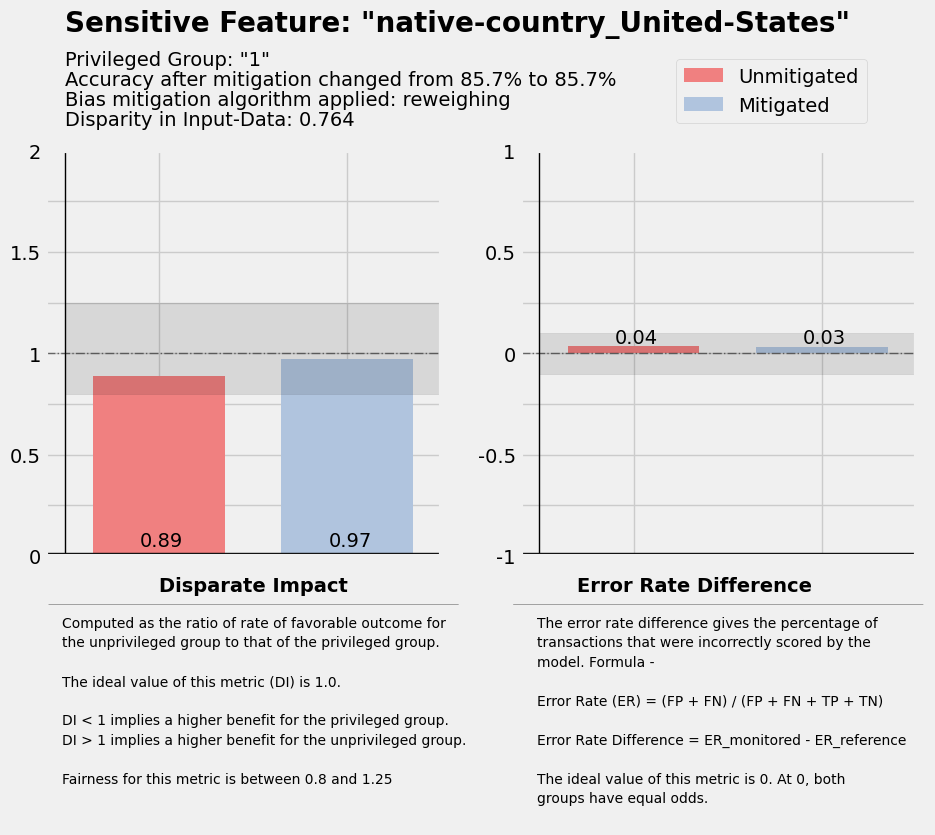

In [6]:
checker = FairAIChecker('native-country_United-States', mitigation_algorithm='reweighing')
checker.fit_predict(X, y)
checker.plot_fairness()